### Main Code

error
process time:15.789578914642334


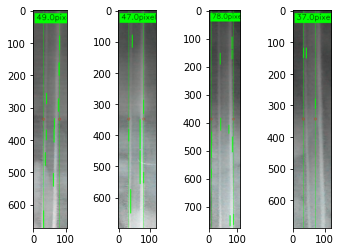

In [9]:
#Read image file
import PIL
from tkinter import *
import tkinter as tk
from PIL import Image, ImageTk
import pytesseract
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from tkinter import messagebox as mb 
from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from keras.models import load_model
import datetime
import time
import shutil
# cnt=0
window = tk.Tk()
window.geometry("800x600")
window.title('RubbingNIP_Mea')

input_path   = './snapimg/'
output_path  = './predict/'
snap_path = './snapimg/'

canva_w=460
canva_h=345
#WebCam parameter set
width, height = 1280,960 #webcam resolution
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
# Yolo Set some parameter
net_h, net_w = 608, 608 # a multiple of 32, the smaller the faster
obj_thresh, nms_thresh = 0.8, 0.45
anchors = [55,69, 75,234, 133,240, 136,129, 142,363, 203,290, 228,184, 285,359, 341,260]
labels = ['type1','type2'] #0,1,2
# Load the model
# infer_model = load_model('./get_nip_yolo3.h5',compile=False)

def show_frame():
    cap.isOpened()
    global rval, frame
    rval, frame = cap.read()
    if rval:
        cv2image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
        img = PIL.Image.fromarray(cv2image).resize((canva_w,canva_h)) #resize for fit GUI
        imgtk = ImageTk.PhotoImage(img)         
        image_canvas.create_image(0,0,anchor=NW,image=imgtk)  
        image_canvas.img = imgtk
    # 10 豪秒 後執行 stream 函式，這裡是模擬 While 迴圈的部分
    window.after(10, show_frame)
    
def Snapshot():
    del_path='./predict/'
    shutil.rmtree(del_path)
    os.mkdir(del_path)
    ss=datetime.datetime.now().strftime('%Y-%m-%d %H%M%S.%f')
    rval, frame = cap.read()
    if rval:
        snap_rgb=frame #for write file
        cv2.imwrite(snap_path+ss+'.jpg',snap_rgb)
        snapimage = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#for show rgb img        
        snapimg = PIL.Image.fromarray(snapimage).resize((canva_w,canva_h))
        snapimgtk = ImageTk.PhotoImage(snapimg)         
        image_canvas_2.create_image(0,0,anchor=NW,image=snapimgtk)  
        image_canvas_2.img = snapimgtk    
#Img Preprocess & detect line
def preprocess_(crop_img,name):
    gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY) #grayscale conversion
    blurred = cv2.GaussianBlur(gray, (5, 5), 0) # 用高斯平滑處理原影象降噪 
    #自適應二值化函式
    im_gray_b = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,25,2)
    # Erosion 影像侵蝕(二值化後)
    kernel = np.ones((3,3), np.uint8)
    erosion = cv2.erode(im_gray_b, kernel, iterations = 3)
    #Dilation 影像膨脹(二值化後)
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(erosion, kernel, iterations = 3) #執行越多次膨脹效果越明顯
    #canny邊緣檢測
    canny = cv2.Canny(dilation, 30, 150) #low_threshold:30, high_threshold:150
    #直線檢測--霍夫直線變換
    #threshold:判斷直線點數的閾值; minLineLength：短於此的線段將被拒絕; maxLineGap 線段之間允許的最大間隙，將它們視為一條線
    lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 100, minLineLength=30, maxLineGap=1) #霍夫直線變換
    lines1 = lines[:, 0, :]  # 提取為二維
    for x1, y1, x2, y2 in lines1[:]:
        if x2 - x1 == 0:
            cv2.line(crop_img,(x1, y1), (x2, y2), (0, 255, 0), 2)
    #判斷斜率
    i=1
    dis=[]
    # 對通過霍夫變換得到的資料進行遍歷
    for line in lines:
        x1,y1,x2,y2 = line[0]  #兩點確定一條直線，這裡就是通過遍歷得到的兩個點的資料 （x1,y1）(x2,y2)
        # 轉換為浮點數，計算斜率
        x1 = float(x1)
        x2 = float(x2)
        y1 = float(y1)
        y2 = float(y2)
        if x2 - x1 == 0: # 垂直線
            result=90
            #記錄所有垂直線的x座標，最大-最小得出垂直線之間的距離
            dis.append(x1)
        i = i+1
    draw_result(crop_img,dis,name)
    lenth=str(max(dis)-min(dis))
#     print('垂直線位置list', sorted(dis))
#     print('直線間距 %s pixel'% str(max(dis)-min(dis)))
    
def draw_result(img1,dis,name):
    path='./result/'
    yaxis=int(img1.shape[0]/2) #img 1/2 high
    lenth=str(max(dis)-min(dis))
    text = lenth+'pixel'
    #Draw result line
    cv2.line(img1, (int(min(dis)), 0), (int(min(dis)),img1.shape[0]), (0, 255, 0), 1)
    cv2.line(img1, (int(max(dis)), 0), (int(max(dis)),img1.shape[0]), (0, 255, 0), 1)
    #result box
    cv2.rectangle(img1, (5, 10), (180, 40), (0, 255, 0), -1) 
    #result text
    cv2.putText(img1, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,0.8, (0,0,0), 1, cv2.LINE_AA)
    #detect point
    cv2.circle(img1, (int(min(dis)),yaxis), 4, (255, 0, 0), 1)
    cv2.circle(img1, (int(max(dis)),yaxis), 4, (255, 0, 0), 1)    
#     plt.title(text)
#     plt.imshow(img1)
#     cv2.imwrite(path +'predict_'+name,img1)
#     plt.show()
    
def yolo():
    global cnt
    cnt=0
    start_time=time.time()
     #遍歷檔案
    image_paths=[]
    if os.path.isdir(input_path): 
        for inp_file in os.listdir(input_path):
            image_paths += [input_path + inp_file]
    else:
        image_paths += [input_path]
    #找出符合之副檔名    
    image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', '.JPG','jpeg'])]

    for image_path in image_paths:
        file=os.path.basename(image_path)[:-4]
        image = cv2.imread(image_path)
    # predict the bounding boxes
        boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors, obj_thresh, nms_thresh)[0]
        if len(boxes)>0: #judge image has any bbox
        # draw bounding boxes on the image using labels
            draw_boxes(image, boxes, labels, obj_thresh)  
            output_img_path = output_path +'predict_'+file+'.jpg'
            cv2.imwrite(output_img_path, np.uint8(image))
#             img = cv2.imread(image_paths[cnt])[:,:,::-1]
    #         img = cv2.cvtColor(cv2.resize(img, (520, 390)), cv2.COLOR_BGR2RGB)
            # Grab the bbox area to predict line Dis.    
            R_sort=[] #for sort bbox location
            AllRegion=[]
            for m in range(len(boxes)):
                if boxes[m].score !=-1:
                    image = cv2.imread(image_path)
#                   # add grab img size:變寬增加解析度 
                    region_raw=boxes[m].label,boxes[m].xmin-10,boxes[m].ymin,boxes[m].xmax+10,boxes[m].ymax,boxes[m].score
                    R_sort.append(region_raw)
                    R_sort.sort(key=lambda region_raw:region_raw[1]) #sort bbox by X axis location
            i=0
            for i in range(len(R_sort)):
                region=image[R_sort[i][2]:R_sort[i][4],R_sort[i][1]:R_sort[i][3]] #取出bbox 的分割圖
                AllRegion.append(region) #append all sorted bbox to a list
                i+=1
            for jj in range(len(AllRegion)):
                name=file+str(jj)+'.jpg'
                preprocess_(AllRegion[jj],name)
        else:
            print('error')
            r=mb.showinfo("info", "影像異常，請重新拍照") 
    # 將量測結果合併為一張圖
    for kk in range(len(AllRegion)):
        img=AllRegion[kk]
        plt.subplot(1,len(AllRegion),kk+1)
        plt.imshow(img)
    plt.savefig('./result/summary.png',dpi=300)
        
    End_time=time.time()
    print('process time:{}'.format(End_time-start_time))
#     print('Click_cnt ',cnt+1)
    cnt+=1
       
def release_cam():
    cap.release()
    
#Canvas_建立顯示WebCam
image_canvas = tk.Canvas(window, bg = '#333f50',height = canva_h, width = canva_w)
image_canvas.place(x = 200, y = 5)

#Canvas_建立顯示拍照
image_canvas_2 = tk.Canvas(window, bg = '#333f50',height = canva_h, width = canva_w)
image_canvas_2.place(x = 700, y = 5)

#Canvas_建立bbox結果
image_canvas_3 = tk.Canvas(window, bg = '#333f50',height = canva_h, width = canva_w)
image_canvas_3.place(x = 200, y = 360)

#Canvas_建立顯示結果
image_canvas_4 = tk.Canvas(window, bg = '#333f50',height = canva_h, width = canva_w)
image_canvas_4.place(x = 700, y = 360)

#Buttom_建立VIEW 
# buttonNext = tk.Button(window,text="View", width = 10, height = 2,activebackground='green',command = lambda:[yolo(),show()])
buttonNext = tk.Button(window,text="View", width = 10, height = 2,activebackground='green',command = show_frame)
buttonNext.place(x = 50, y = 100)
#Snapshot buttom
Snapbutton = tk.Button(window,text="拍照", width = 10, height = 2,activebackground='green',command = Snapshot)
Snapbutton.place(x = 50, y = 200)
#Mea buttom
# Meabutton = tk.Button(window,text="量測", width = 10, height = 2,activebackground='green',command = yolo)
Meabutton = tk.Button(window,text="量測", width = 10, height = 2,activebackground='green',command=lambda:[yolo(),result()])
Meabutton.place(x = 50, y = 300)
#Buttom_Close Buttom 
buttonClose = tk.Button(window,text='離開程式',width=15,height =5,activebackground='green', font=('Helvetica', '10'),command=lambda:[window.destroy(),release_cam()])
buttonClose.place(x = 20, y = 500)

window.mainloop()

In [6]:
def result():
    #Show yolo predict Result Image
    result_paths=[]
    if os.path.isdir(output_path): 
        for inp_file in os.listdir(output_path):
            result_paths += [output_path + inp_file]
    else:
        result_paths += [output_path]
    result_paths = [inp_file for inp_file in result_paths if (inp_file[-4:] in ['.jpg', '.png', '.JPG','jpeg'])]
    for result_path in result_paths:
        result=cv2.imread(result_path)
        resultimage = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)#for show rgb img        
        resultimg = PIL.Image.fromarray(resultimage).resize((canva_w,canva_h))
        resultimgtk = ImageTk.PhotoImage(resultimg)         
        image_canvas_3.create_image(0,0,anchor=NW,image=resultimgtk)  
        image_canvas_3.img = resultimgtk  
    #Show Measure Result Image    
    final=cv2.imread('./result/summary.png')
    finalimage = PIL.Image.fromarray(final).resize((canva_w,canva_h))
    finalimgtk = ImageTk.PhotoImage(finalimage)         
    image_canvas_4.create_image(0,0,anchor=NW,image=finalimgtk)  
    image_canvas_4.img = finalimgtk 

In [7]:
#清空資料夾檔案
path='./predict/'
shutil.rmtree(path)
os.mkdir(path)